In [1]:
from HeaderP import *

In [2]:
import Astraea

# load simulation

In [169]:
Rcut_thread=25
data=pd.read_pickle('./Tobias/g8.26e11.pkl')
data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
data['R']=np.sqrt(data['x']**2+data['y']**2)
#data['dR']=data['R']-data['R_bir']


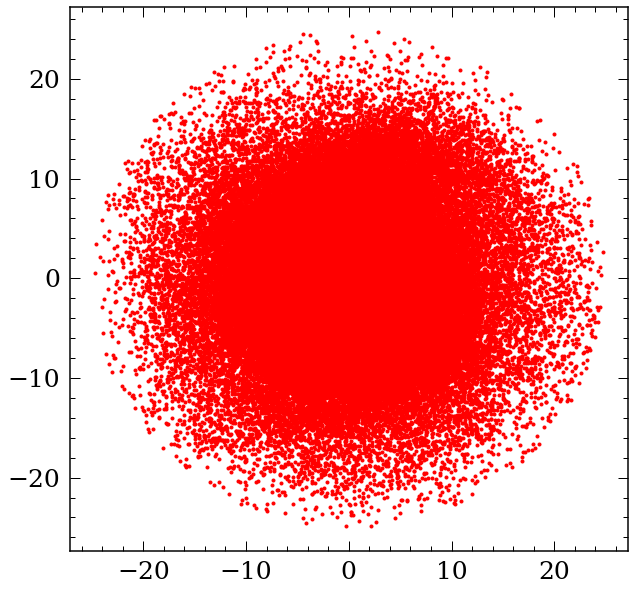

In [170]:
plt.plot(data['x'],data['y'],'r.')

In [171]:
m_sr = (data['Rbir']>7)&(data['Rbir']<9)
data_sr = data[m_sr]

In [172]:
snapshotnames = np.load('./Tobias/snapshots.npy')
ages = np.load('./Tobias/cosmictime.npy')

In [173]:
agelookup = {snapshotnames[i]:ages[i] for i in range(len(ages))}

In [174]:
xcols = [i for i in data_sr.columns if 'x_' in i] 
ycols = [i for i in data_sr.columns if 'y_' in i] 

snaps = [i.split('_')[-1] for i in xcols]

In [175]:
dr = np.zeros(0)
cosmictime = np.zeros(0)
for i in range(len(snaps)):
    data_snap = data_sr.dropna(subset=[xcols[i],ycols[i]])
    R = np.sqrt(data_snap[xcols[i]]**2+data_snap[ycols[i]]**2).values
    Rb = data_snap['Rbir'].values
    dr = np.append(dr, R-Rb)
    cosmictime = np.append(cosmictime, np.ones(len(data_snap))*agelookup[snaps[i]])

In [176]:
def SlideMed(age, dr, window, slide):
    age, dr = np.array(age), np.array(dr)
    minage, maxage = min(age), max(age)
    npoints = int((maxage-minage)/slide)
    medage = np.zeros(npoints)*np.nan
    meddr = np.zeros(npoints)*np.nan
    for i in trange(npoints):
        if i==0:
            m_w = (age<window)
        elif i==npoints-1:
            m_w = (age>(maxage-window))
        else:
            m_w = ((age>(i*slide-window+minage))&(age<(i*slide+window+minage)))
        #print(sum(m_w))
        medage[i], meddr[i] = np.mean(age[m_w]), np.mean(dr[m_w])
    m_nan = (meddr==meddr)
    medage, meddr = medage[m_nan], meddr[m_nan]
    return medage, meddr
        

In [177]:
print(np.shape(dr), np.shape(cosmictime))

(588002,) (588002,)


  0%|          | 0/4854 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 4854/4854 [00:01<00:00, 3910.50it/s]


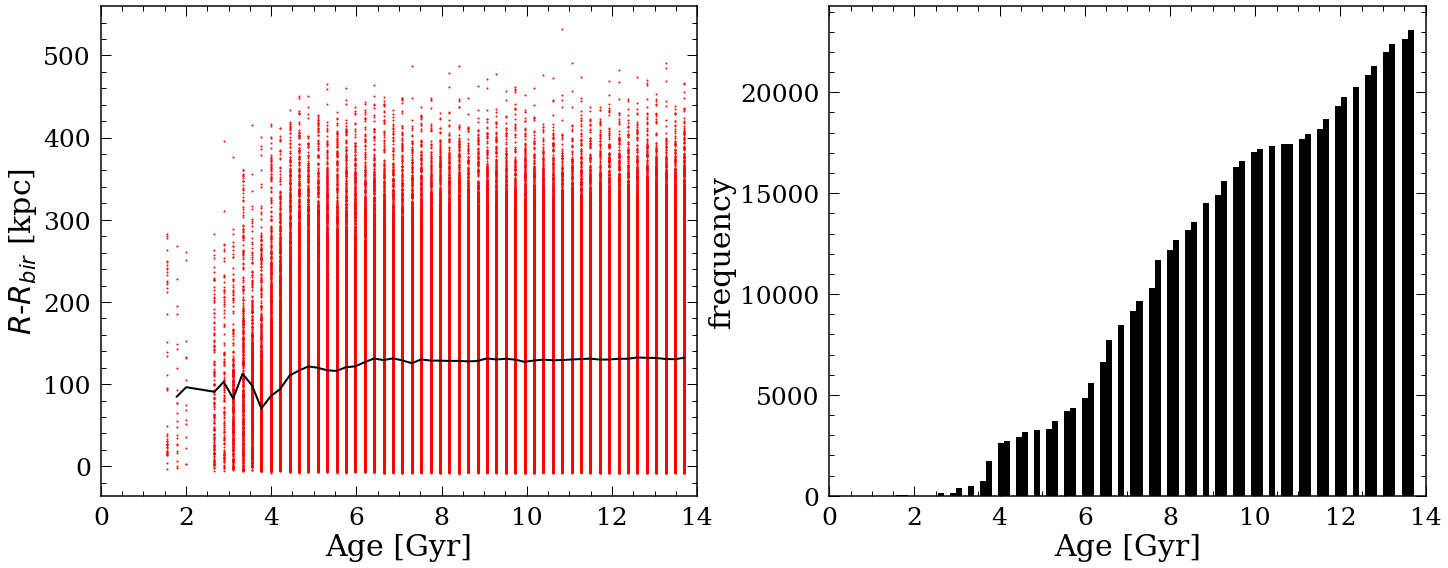

In [206]:
from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
age_order, dr_order = zip(*sorted(zip(cosmictime, dr)))
plt.scatter(age_order, dr_order,s=1,c='r')
age_smooth, dr_smooth = SlideMed(age_order, dr_order, 0.0025/2, 0.0025)
plt.plot(age_smooth, dr_smooth,'k-')
plt.xlabel('Age [Gyr]')
plt.ylabel('$R$-$R_{bir}$ [kpc]')
plt.xlim([0,14])

plt.subplot(1,2,2)
plt.hist(age_order,bins=np.linspace(0,14,100),color='k')
plt.xlabel('Age [Gyr]')
plt.ylabel('frequency')
plt.xlim([0,14])
plt.tight_layout()

<ipython-input-207-adc3ff66fcbc>:26: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, 50/xf, 'r--',label='1/$f$ (pink noise)',linewidth=5)
<ipython-input-207-adc3ff66fcbc>:27: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, 50/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)


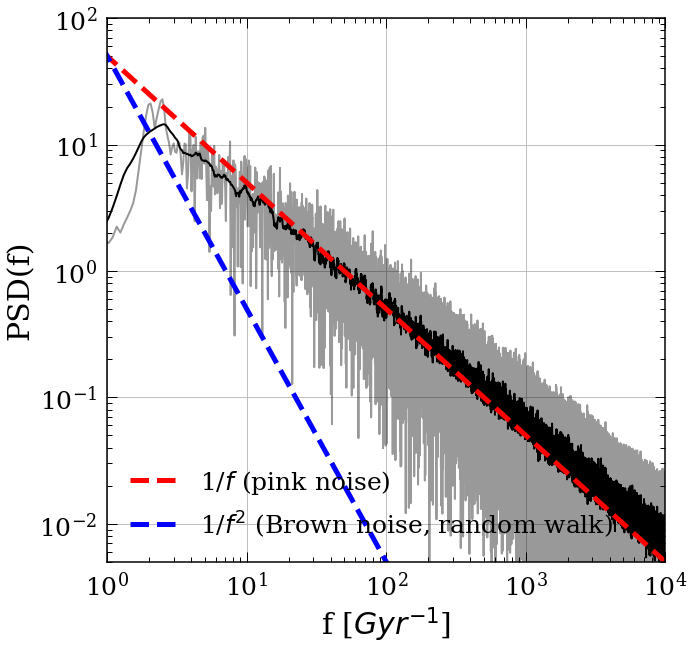

In [207]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq


N = len(age_order)
T = max(age_order)/N
yf = fft(dr_order)

"""
N = len(age_smooth)
T = max(age_smooth)/N
yf = fft(dr_smooth)
"""

xf = fftfreq(N, T)[:N//2]

import matplotlib.pyplot as plt
PSD = 2.0/N * np.abs(yf[0:N//2])
plt.loglog(xf,PSD,'k-',alpha=0.4)

#PSD_smooth = gaussian_filter1d(PSD, 5)
PSD_smooth = savgol_filter(PSD, 21, 1)
plt.loglog(xf,PSD_smooth,'k-')

plt.plot(xf, 50/xf, 'r--',label='1/$f$ (pink noise)',linewidth=5)
plt.plot(xf, 50/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)
plt.grid()
plt.xlim([1,1e4])
plt.ylim([5e-3,1e2])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.legend(loc=3)

In [208]:
from astropy.timeseries import LombScargle
periods = np.linspace(0.1, 14, 1000)
#power = LombScargle(data_sr['age'], data_sr['dR']).power(frequency)
power = LombScargle(age_smooth, dr_smooth).power(2*np.pi/periods)

Text(0, 0.5, 'LS Power')

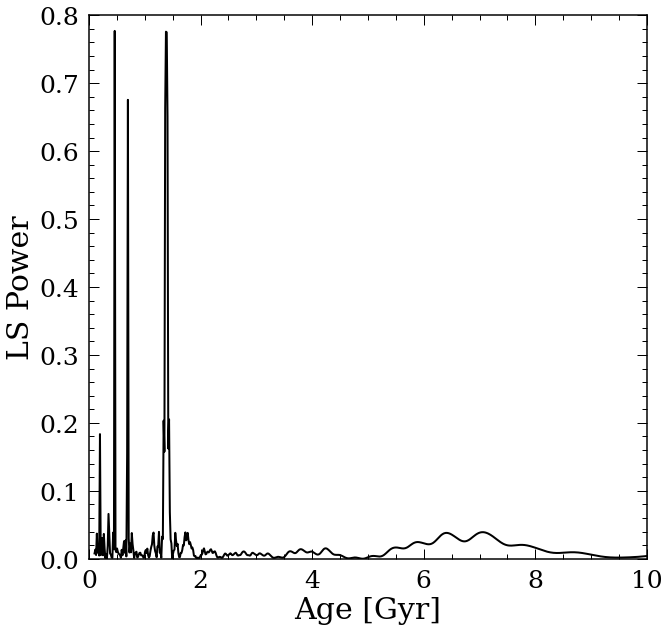

In [209]:
plt.plot(periods, np.array(power,dtype=float),'k-')
plt.ylim([0,0.8])
plt.xlim([0,10])
plt.xlabel('Age [Gyr]')
plt.ylabel('LS Power')

# Use the last snapshot

<ipython-input-191-367649e36a61>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sr['dR'] = data_sr['R']-data_sr['Rbir']
  0%|          | 0/5195 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 5195/5195 [00:00<00:00, 35358.70it/s]


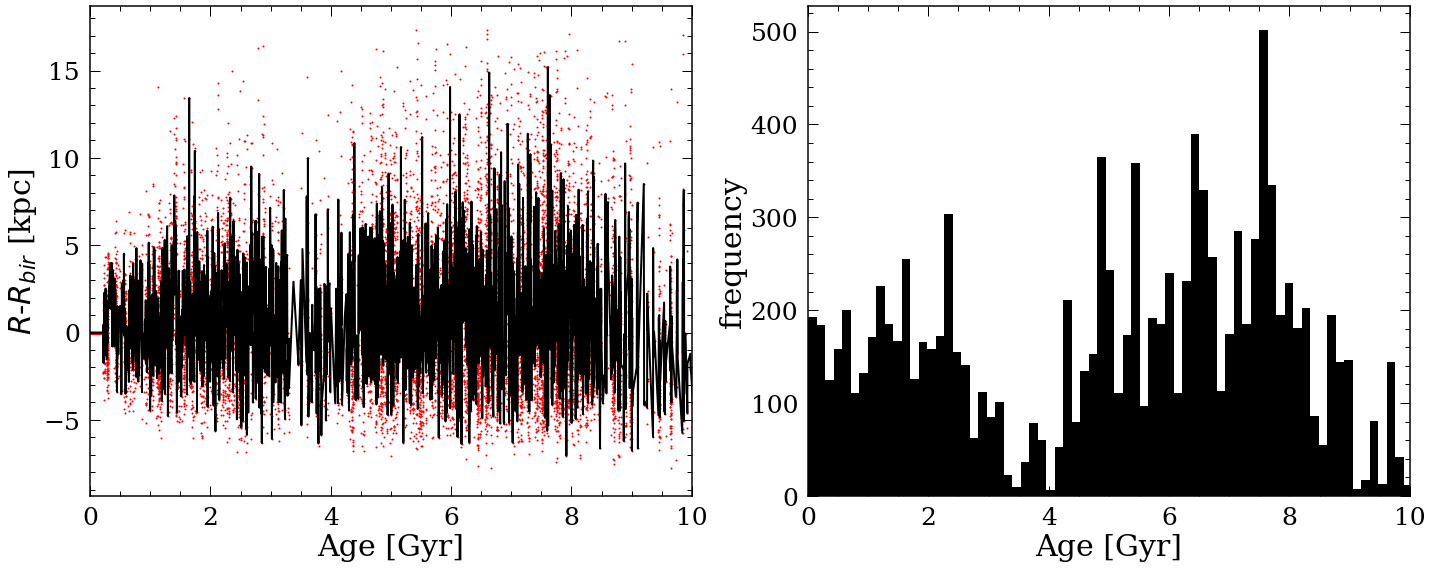

In [191]:
from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(20,8))
m = ((data['Rbir']>7)&(data['Rbir']<9))
data_sr=data[m]
data_sr['dR'] = data_sr['R']-data_sr['Rbir']
plt.subplot(1,2,1)
age_order_sel, dr_order_sel = zip(*sorted(zip(data_sr['age'],data_sr['dR'])))
plt.scatter(age_order_sel, dr_order_sel,s=1,c='r')
age_smooth_sel, dr_smooth_sel = SlideMed(data_sr['age'].values, data_sr['dR'].values, 0.0025/2, 0.0025)
plt.plot(age_smooth_sel, dr_smooth_sel,'k-')
plt.xlabel('Age [Gyr]')
plt.ylabel('$R$-$R_{bir}$ [kpc]')
plt.xlim([0,10])

plt.subplot(1,2,2)
plt.hist(age_order_sel,bins=np.linspace(0,14,100),color='k')
plt.xlabel('Age [Gyr]')
plt.ylabel('frequency')
plt.xlim([0,10])
plt.tight_layout()

<ipython-input-203-e70afc223d0c>:23: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, 0.6/xf, 'r--',label='1/$f$ (pink noise)',linewidth=5)
<ipython-input-203-e70afc223d0c>:24: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, 2/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)


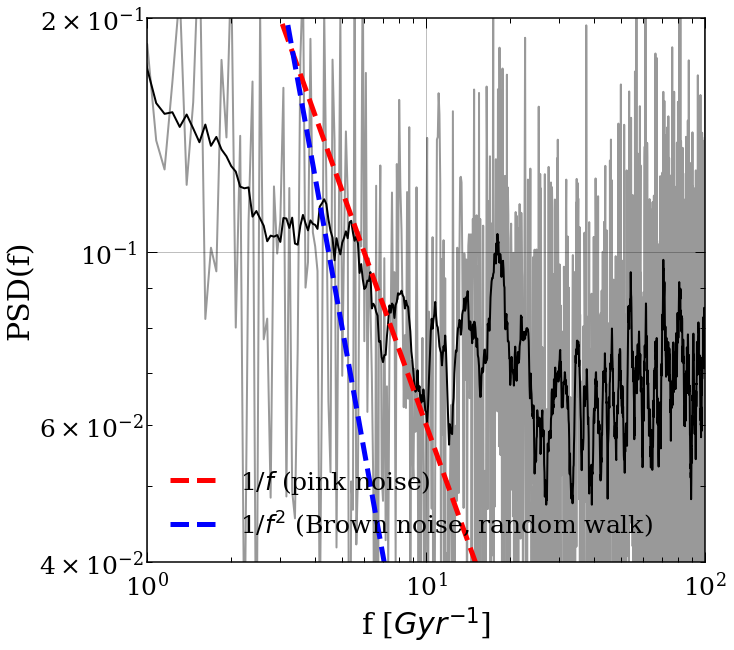

In [203]:

from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq

N = len(age_order_sel)
T = max(age_order_sel)/N
yf = fft(dr_order_sel)
"""
N = len(age_smooth_sel)
T = max(age_smooth_sel)/N
yf = fft(dr_smooth_sel)
"""

xf_sel = fftfreq(N, T)[:N//2]


PSD_sel = 2.0/N * np.abs(yf[0:N//2])
plt.loglog(xf_sel,PSD_sel,'k-',alpha=0.4)

#PSD_smooth = gaussian_filter1d(PSD, 5)
PSD_smooth_sel = savgol_filter(PSD_sel, 21, 1)
plt.loglog(xf_sel,PSD_smooth_sel,'k-')

plt.plot(xf, 0.6/xf, 'r--',label='1/$f$ (pink noise)',linewidth=5)
plt.plot(xf, 2/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)
plt.grid()
plt.xlim([1,1/0.01])
plt.ylim([4e-2,2e-1])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.legend(loc=3)

In [204]:
from astropy.timeseries import LombScargle
periods = np.linspace(0.1, 10, 1000)
power = LombScargle(age_order_sel, dr_order_sel).power(2*np.pi/periods)

Text(0, 0.5, 'LS Power')

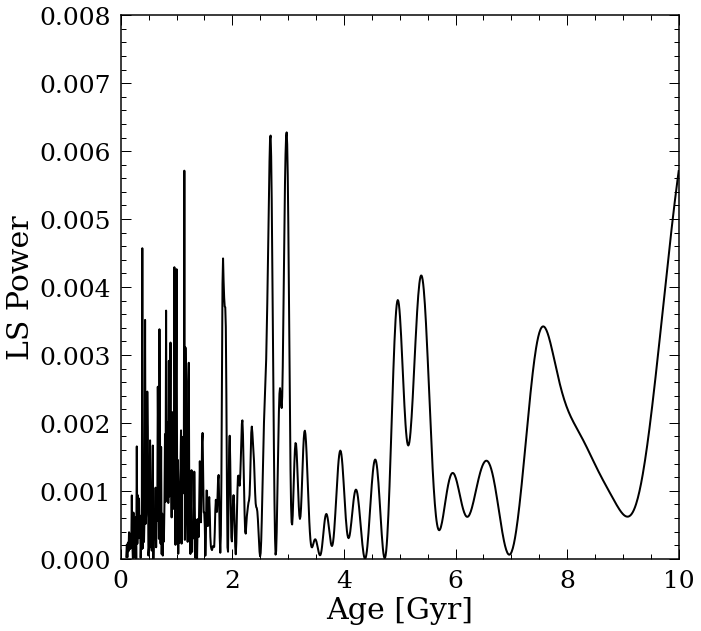

In [205]:
plt.plot(periods, np.array(power,dtype=float),'k-')
plt.ylim([0,0.008])
plt.xlim([0,10])
plt.xlabel('Age [Gyr]')
plt.ylabel('LS Power')